In [11]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

# import better_exceptions
from scikit_quri.qnn.regressor import QNNRegressor
import numpy as np
from typing import Optional
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
from quri_parts.circuit import UnboundParametricQuantumCircuit,LinearMappedUnboundParametricQuantumCircuit
from numpy.random import default_rng

from qulacs import Observable
from quri_parts.core.operator import Operator, pauli_label
from quri_parts.core.estimator.gradient import (
    create_parameter_shift_gradient_estimator,
    create_numerical_gradient_estimator)
from quri_parts.qulacs.estimator import (
    create_qulacs_vector_estimator,
    create_qulacs_vector_parametric_estimator,
    create_qulacs_vector_concurrent_parametric_estimator,
    create_qulacs_vector_concurrent_estimator,
)
from quri_parts.algo.optimizer import Adam, LBFGS
from scikit_quri.circuit import LearningCircuit
from scikit_quri.circuit.pre_defined import create_farhi_neven_ansatz,create_qcl_ansatz

def generate_noisy_sine(x_min, x_max, num_x):
    rng = default_rng(0)
    x_train = [[rng.uniform(x_min, x_max)] for _ in range(num_x)]
    y_train = [np.sin(np.pi * x[0]) for x in x_train]
    mag_noise = 0.01
    y_train += mag_noise * rng.random(num_x)
    # return np.array(x_train), np.array(y_train)
    return np.array(x_train).flatten(), np.array(y_train)

x_train,y_train = generate_noisy_sine(-1.,1.,80)
x_test,y_test = generate_noisy_sine(-1.,1.,80)

In [12]:
from scikit_quri.circuit import LearningCircuit
from quri_parts.circuit.utils.circuit_drawer import draw_circuit
import matplotlib.pyplot as plt
n_qubits = 4
depth = 6
n_outputs = 1
# parametric_circuit = create_farhi_neven_ansatz(n_qubits,depth,1)
parametric_circuit = create_qcl_ansatz(n_qubits,depth,0.5,0)

op = Operator()
for i in range(n_outputs):
    op.add_term(pauli_label(f"Z {i}"),1.0)
draw_circuit(parametric_circuit.circuit)
# estimator = create_qulacs_vector_estimator()
estimator = create_qulacs_vector_concurrent_estimator()
# gradient_estimator = create_parameter_shift_gradient_estimator(create_qulacs_vector_concurrent_parametric_estimator())
gradient_estimator = create_numerical_gradient_estimator(create_qulacs_vector_concurrent_parametric_estimator(),delta=1e-10)
adam = Adam()

   ___     ___     ___     ___     ___     ___     ___     ___     ___     ___  
  |PRY|   |PRZ|   |Mat|   |PRX|   |PRZ|   |PRX|   |Mat|   |PRX|   |PRZ|   |PRX| 
--|0  |---|1  |---|8  |---|9  |---|10 |---|11 |---|21 |---|22 |---|23 |---|24 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|2  |---|3  |---|   |---|12 |---|13 |---|14 |---|   |---|25 |---|26 |---|27 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    ___     ___     ___    |   |    ___     ___     ___  
  |PRY|   |PRZ|   |   |   |PRX|   |PRZ|   |PRX|   |   |   |PRX|   |PRZ|   |PRX| 
--|4  |---|5  |---|   |---|15 |---|16 |---|17 |---|   |---|28 |---|29 |---|30 |-
  |___|   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |___|   |___| 
   ___     ___    |   |    _

In [13]:
init_params = 2*np.pi*np.random.rand(parametric_circuit.n_learning_params)
print(init_params)

[5.09514467e+00 6.26943509e+00 4.90087620e+00 5.41691340e+00
 3.14017606e-01 1.73999865e+00 6.21714762e+00 1.08161632e+00
 3.81728115e+00 2.65054696e+00 2.94984061e+00 2.33020673e+00
 4.33479756e+00 9.24349756e-01 2.14906746e+00 1.17504765e+00
 1.82982065e-01 2.67548410e-01 5.06536348e+00 6.26098285e+00
 2.46951012e+00 1.26159505e-03 3.39424141e+00 1.23701248e+00
 5.75889025e+00 4.58469661e+00 4.46835677e+00 6.42200534e-01
 6.27508208e+00 2.22265251e-01 3.69654777e+00 4.28109364e+00
 1.72797407e+00 4.53790159e+00 3.32439209e+00 2.45620405e+00
 6.02722909e+00 1.23451244e-01 3.25695593e+00 1.33944096e-01
 3.49988461e+00 1.86493384e-01 2.49082975e+00 2.22198436e+00
 1.30759522e+00 4.76796778e+00 6.04847830e+00 2.54676755e+00
 5.04194818e+00 3.72528141e+00 1.18673758e+00 6.02454754e+00
 5.46732034e+00 3.11321838e+00 3.99774515e+00 2.72182211e-01
 2.53575588e+00 4.46311239e+00 3.44508368e+00 4.48066372e+00
 1.36107743e+00 2.64880011e+00 1.44634327e-01 2.63968342e+00
 5.78427910e+00 4.647983

In [14]:
qnn = QNNRegressor(n_qubits,parametric_circuit,estimator,gradient_estimator,adam,op)

# qnn.grad_fn(x_train.reshape((-1,1)),y_train.reshape((-1,1)),params=init_params)
qnn.fit(x_train,y_train,maxiter=30)

parameter_count=72
init_params=array([5.13778152, 5.51512923, 0.15849941, 6.27581379, 0.29719736,
       5.27101602, 2.23326432, 5.26766592, 4.27674417, 3.88942749,
       4.72484171, 2.84234377, 0.96187528, 3.51161512, 5.40556752,
       3.22976207, 4.37208561, 0.1328334 , 5.74145352, 4.22957216,
       4.77444762, 2.97307591, 4.62605508, 2.34698881, 4.06746149,
       1.11488672, 0.4269737 , 2.21831932, 1.32541698, 2.85951463,
       0.80389163, 1.4968188 , 1.14337926, 0.17032519, 0.83032364,
       5.13411047, 5.32382244, 2.67626573, 0.9342657 , 1.96530433,
       3.39896816, 4.63973556, 0.05715182, 4.70150558, 1.38244115,
       2.9879261 , 1.30805954, 0.59650363, 4.49370417, 3.31811248,
       1.95282388, 6.18268133, 1.98263407, 2.78542907, 4.9968177 ,
       5.45943334, 0.30726186, 4.10142139, 1.21872294, 4.92964865,
       0.7751851 , 5.41586914, 5.47705437, 2.73708979, 0.09569863,
       5.97727582, 0.4461769 , 1.6105926 , 0.20552232, 5.90194792,
       0.70565324, 4.17611302])

cost=0.007812699230304336


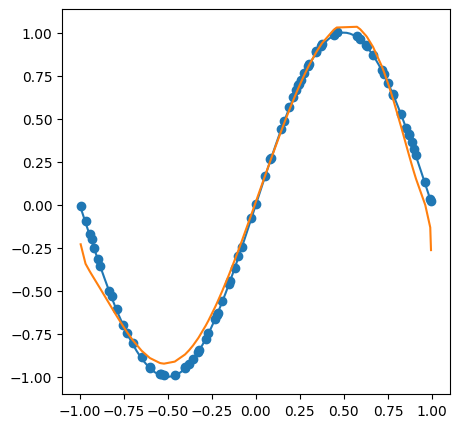

In [15]:
y_pred = qnn.predict(x_test)
y_test = y_test.reshape(-1,1)
plt.figure(figsize=(5,5))

# plt.plot(x_test,y_test,marker="o",color="orange",label="Test")
plt.scatter(
    np.sort(x_test),
    y_test[np.argsort(x_test.flatten())],label="Test")

x_true = np.linspace(-1,1,100)
y_true = np.sin(np.pi * x_true)
plt.plot(x_true,y_true,label="True")
plt.plot(
    np.sort(x_test.flatten()),
    y_pred[np.argsort(x_test.flatten())],
    label="Prediction")
# plt.legend()
from sklearn.metrics import mean_squared_error
cost = mean_squared_error(y_test,y_pred)
print(f"{cost=}")
plt.show()